In [1]:
import os
import tensorflow as tf

datadir = "/Users/alison/Documents/DPhil/multivariate/"
import numpy as np
from hazardGAN import utils, fig_utils
from importlib import reload
import matplotlib.pyplot as plt

import os
import wandb
import hazardGAN
import wandb
from hazardGAN import DCGAN, tDCGAN
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from importlib import reload

Metal device set to: Apple M2


In [5]:
wd = "/Users/alison/Documents/DPhil/multivariate/hazardGAN"

RUNNAME = 'colorful-fog-13' # 'pleasant-cherry-12' #'tough-paper-11' #'solar-wind-126' ##'icy-frog-125' # 'solar-sweep-1' # 'leafy-plant-114'
evt_type = 'bm'
pot = (evt_type == "pot")

os.chdir(os.path.join(wd, 'saved-temporal-models', evt_type, RUNNAME))

wandb.init(project='test', mode='disabled')
dcgan = DCGAN(wandb.config, nchannels=3)
tdcgan = tDCGAN(wandb.config, nchannels=3)
tdcgan.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_15 (Dense)            (None, 128000)            12928000  
                                                                 
 reshape_57 (Reshape)        (None, 5, 5, 5, 1024)     0         
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 5, 5, 5, 1024)     0         
                                                                 
 spatial_dropout3d_21 (Spati  (None, 5, 5, 5, 1024)    0         
 alDropout3D)                                                    
                                                                 
 reshape_58 (Reshape)        (None, 125, 1024)         0         
                                                         

In [3]:
tdcgan.generator.

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 25600)             2585600   
                                                                 
 reshape_2 (Reshape)         (None, 5, 5, 1024)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 5, 5, 1024)       4096      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 5, 5, 1024)        0         
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 1024)        0         
                                                         

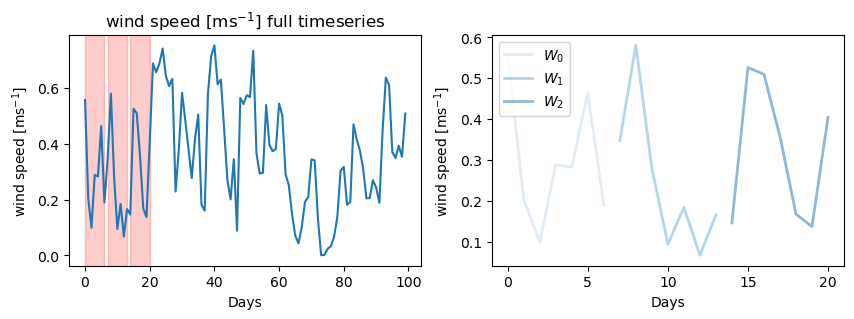

In [93]:
reload(utils)
window = 7
step = 7

# load data
res = utils.load_training_data(datadir,
                                datas=['wind_data', 'wave_data', 'precip_data'],
                                train_size=100,
                                evt_type='bm',
                                shuffle=False)
marginals_train, marginals_test, params, images, thresholds = res

# sliding windows
n, h, w, c = marginals_train.shape
marginal_windows = utils.sliding_windows(marginals_train, window, step)
window_indices = utils.sliding_window_indices(window, n, step)
window_slides = [[x[0], x[-1]] for x in window_indices[:3]]

channel = 0
i, j = 10, 12
nwindows = 3
cmap = plt.get_cmap('Blues')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot([*range(100)], marginals_train[:, i, j, channel], color='C0')
for slide in window_slides:
    axs[0].axvspan(slide[0], slide[1], color='red', alpha=0.2)

for window in range(nwindows):
    axs[1].plot(window_indices[window], marginal_windows[window, :, i, j, channel],
                label=r'$W_{}$'.format(window), color=cmap((window+1)/(nwindows+1)),
                linewidth=2, alpha=.5)

for ax in axs:
    ax.set_xlabel('Days')
    ax.set_ylabel(fig_utils.channel_labels[channel])
axs[1].legend(loc='upper left')
axs[0].set_title('{} full timeseries'.format(fig_utils.channel_labels[channel]));
axs[0].set_title('{} full timeseries'.format(fig_utils.channel_labels[channel]));

In [80]:
dataset = tf.data.Dataset.from_tensor_slices(marginal_windows).batch(50)
first_batch = next(iter(dataset))
first_batch.shape

TensorShape([14, 7, 20, 24, 3])

In [89]:

reload(hazardGAN)


dcgan = hazardGAN.tDCGAN.compile_dcgan(config, nchannels=3)

# dcgan.generator.load_weights(os.path.join(wd, 'saved-temporal-models', evt_type, RUNNAME, f'generator_weights'))
generated = dcgan(1)
generated = utils.unpad(generated, paddings=tf.constant([[0,0], [0, 0], [1,1], [1,1], [0,0]]))

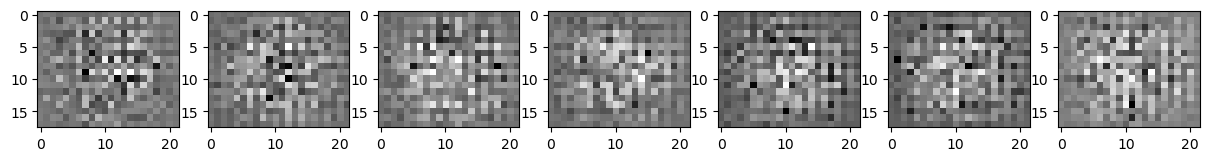

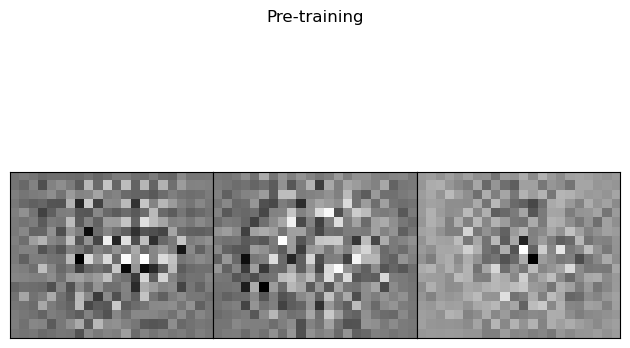

In [90]:
# pre-training animations
import time

generated = dcgan(1)
generated = utils.unpad(generated, paddings=tf.constant([[0,0], [0, 0], [1,1], [1,1], [0,0]]))

n, T, h, w, c = generated.shape
channel = 0
fig, axs = plt.subplots(1, T, figsize=(15, 3))
for t in range(T):
    axs[t].imshow(generated[0, t, ..., channel], cmap="Greys")
    
def update_plot(frame):
    n, t, h, w, c = generated.shape
    #plt.clf()  # clear the previous plot
    for i in range(generated.shape[-1]):
        axs[i].clear()
        axs[i].imshow(generated[0, frame, ..., i], cmap='Greys')  # plot the current frame
        axs[i].set_xticks([])
        axs[i].set_yticks([])

#     if frame % 7 == 0:
#         for i in range(generated.shape[-1]):
#             axs[i].clear()
#             blank = np.zeros((h, w)) #endmat()
#             axs[i].imshow(blank, cmap='Greys_r')  # plot the current frame
#             axs[i].set_xticks([])
#             axs[i].set_yticks([])
#         time.sleep(2)

fig, axs = plt.subplots(1, 3, gridspec_kw={'wspace': 0}, layout='tight')
ani = FuncAnimation(fig, update_plot, frames=generated.shape[1], interval=400);
fig.suptitle('Pre-training')
ani.save('/Users/alison/Desktop/gifs/pretraining-animation.gif')

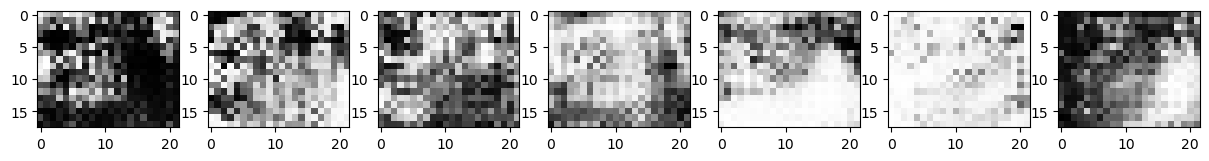

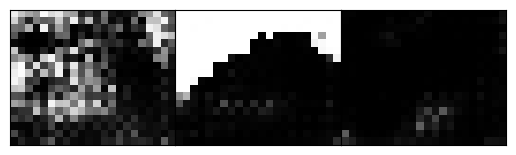

In [91]:
# post-training animations
dcgan.generator.load_weights(os.path.join(wd, 'saved-temporal-models', evt_type, RUNNAME, f'generator_weights'))
generated = dcgan(1)
generated = utils.unpad(generated, paddings=tf.constant([[0,0], [0, 0], [1,1], [1,1], [0,0]]))

n, T, h, w, c = generated.shape
channel = 0
fig, axs = plt.subplots(1, T, figsize=(15, 3))
for t in range(T):
    axs[t].imshow(generated[0, t, ..., channel], cmap="Greys")
    
fig.savefig('/Users/alison/Desktop/gifs/posttraining-animation.png')
    
def update_plot(frame):
    n, t, h, w, c = generated.shape
    #plt.clf()  # clear the previous plot
    for i in range(generated.shape[-1]):
        axs[i].clear()
        axs[i].imshow(generated[0, frame, ..., i], cmap='Greys', vmin=0, vmax=1)  # plot the current frame
        axs[i].set_xticks([])
        axs[i].set_yticks([])

#     if frame % generated.shape[1] == 0: # pause every 7 frames
#         for i in range(generated.shape[-1]):
#             axs[i].clear()
#             blank = np.zeros((h, w)) #endmat()
#             axs[i].imshow(blank, cmap='Greys_r')  # plot the current frame
#             axs[i].set_xticks([])
#             axs[i].set_yticks([])
#         time.sleep(2)
        
fig, axs = plt.subplots(1, 3, gridspec_kw={'wspace': 0})
ani = FuncAnimation(fig, update_plot, frames=generated.shape[1], interval=200);

ani.save('/Users/alison/Desktop/gifs/posttraining-animation.gif')

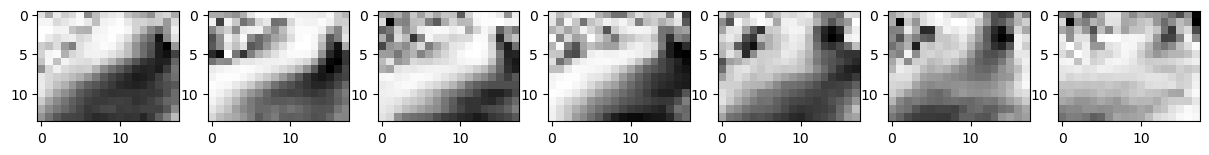

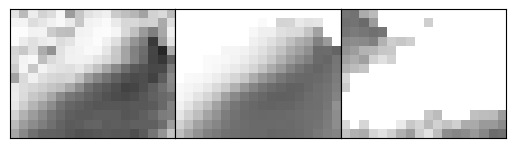

In [92]:
# post-training animations
marginal_windows = utils.unpad(marginal_windows, paddings=tf.constant([[0,0], [0, 0], [1,1], [1,1], [0,0]]))

n, T, h, w, c = marginal_windows.shape
channel = 0
fig, axs = plt.subplots(1, T, figsize=(15, 3))
for t in range(T):
    axs[t].imshow(marginal_windows[0, t, ..., channel], cmap="Greys")
fig.savefig('/Users/alison/Desktop/gifs/training-animation.png')


def update_plot(frame):
    n, t, h, w, c = marginal_windows.shape
    #plt.clf()  # clear the previous plot
    for i in range(marginal_windows.shape[-1]):
        axs[i].clear()
        axs[i].imshow(marginal_windows[0, frame, ..., i], cmap='Greys', vmin=0, vmax=1)  # plot the current frame
        axs[i].set_xticks([])
        axs[i].set_yticks([])

#     if frame % marginal_windows.shape[1] == 0: # pause every 7 frames
#         for i in range(marginal_windows.shape[-1]):
#             axs[i].clear()
#             blank = np.zeros((h, w)) #endmat()
#             axs[i].imshow(blank, cmap='Greys_r')  # plot the current frame
#             axs[i].set_xticks([])
#             axs[i].set_yticks([])
#         time.sleep(2)
        
fig, axs = plt.subplots(1, 3, gridspec_kw={'wspace': 0})
ani = FuncAnimation(fig, update_plot, frames=marginal_windows.shape[1], interval=200);

ani.save('/Users/alison/Desktop/gifs/training-animation.gif')

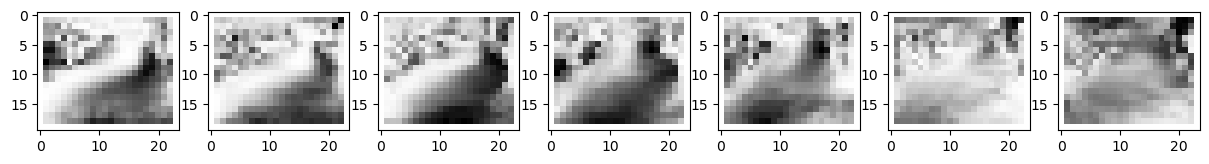

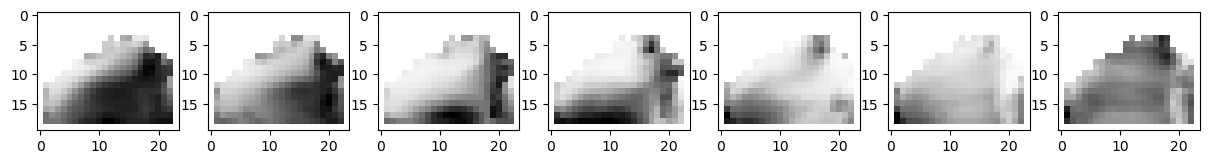

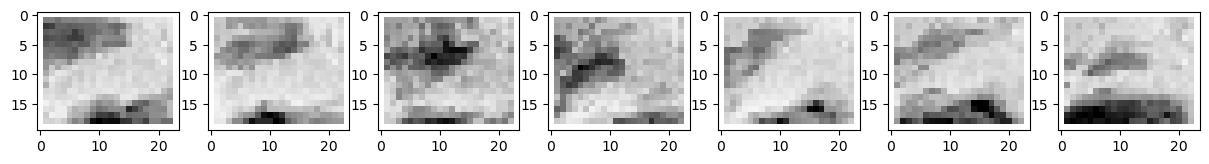

In [13]:
for channel in range(3):
    fig, axs = plt.subplots(1, T, figsize=(15, 3))
    for t in range(T):
        axs[t].imshow(marginal_windows[1, t, ..., channel], cmap="Greys")

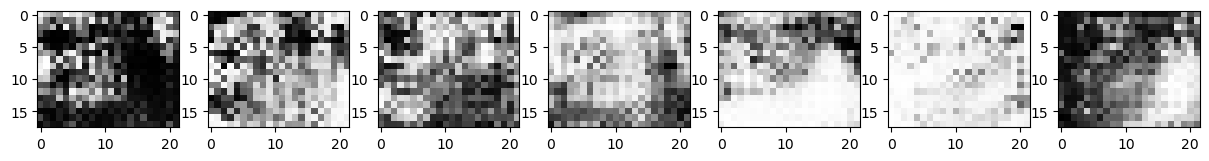

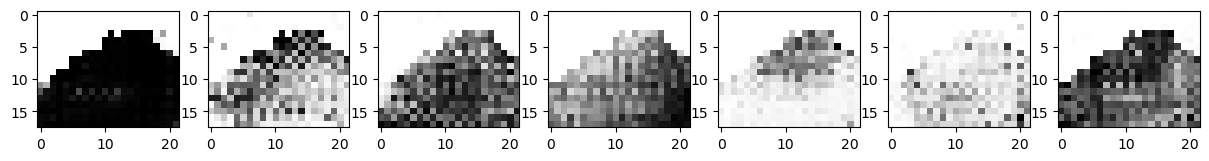

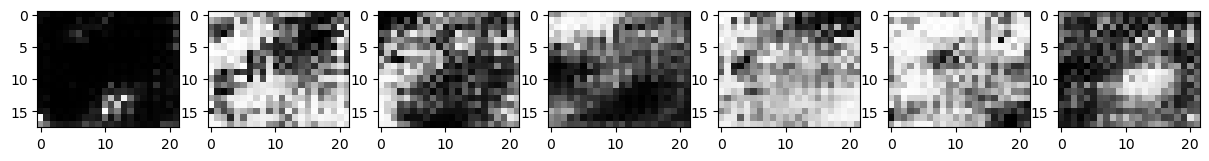

In [11]:
for channel in range(3):
    fig, axs = plt.subplots(1, T, figsize=(15, 3))
    for t in range(T):
        axs[t].imshow(generated[0, t, ..., channel], cmap="Greys")

In [9]:
ani.save('/Users/alison/Desktop/posttraining-animation.gif')